In [35]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math


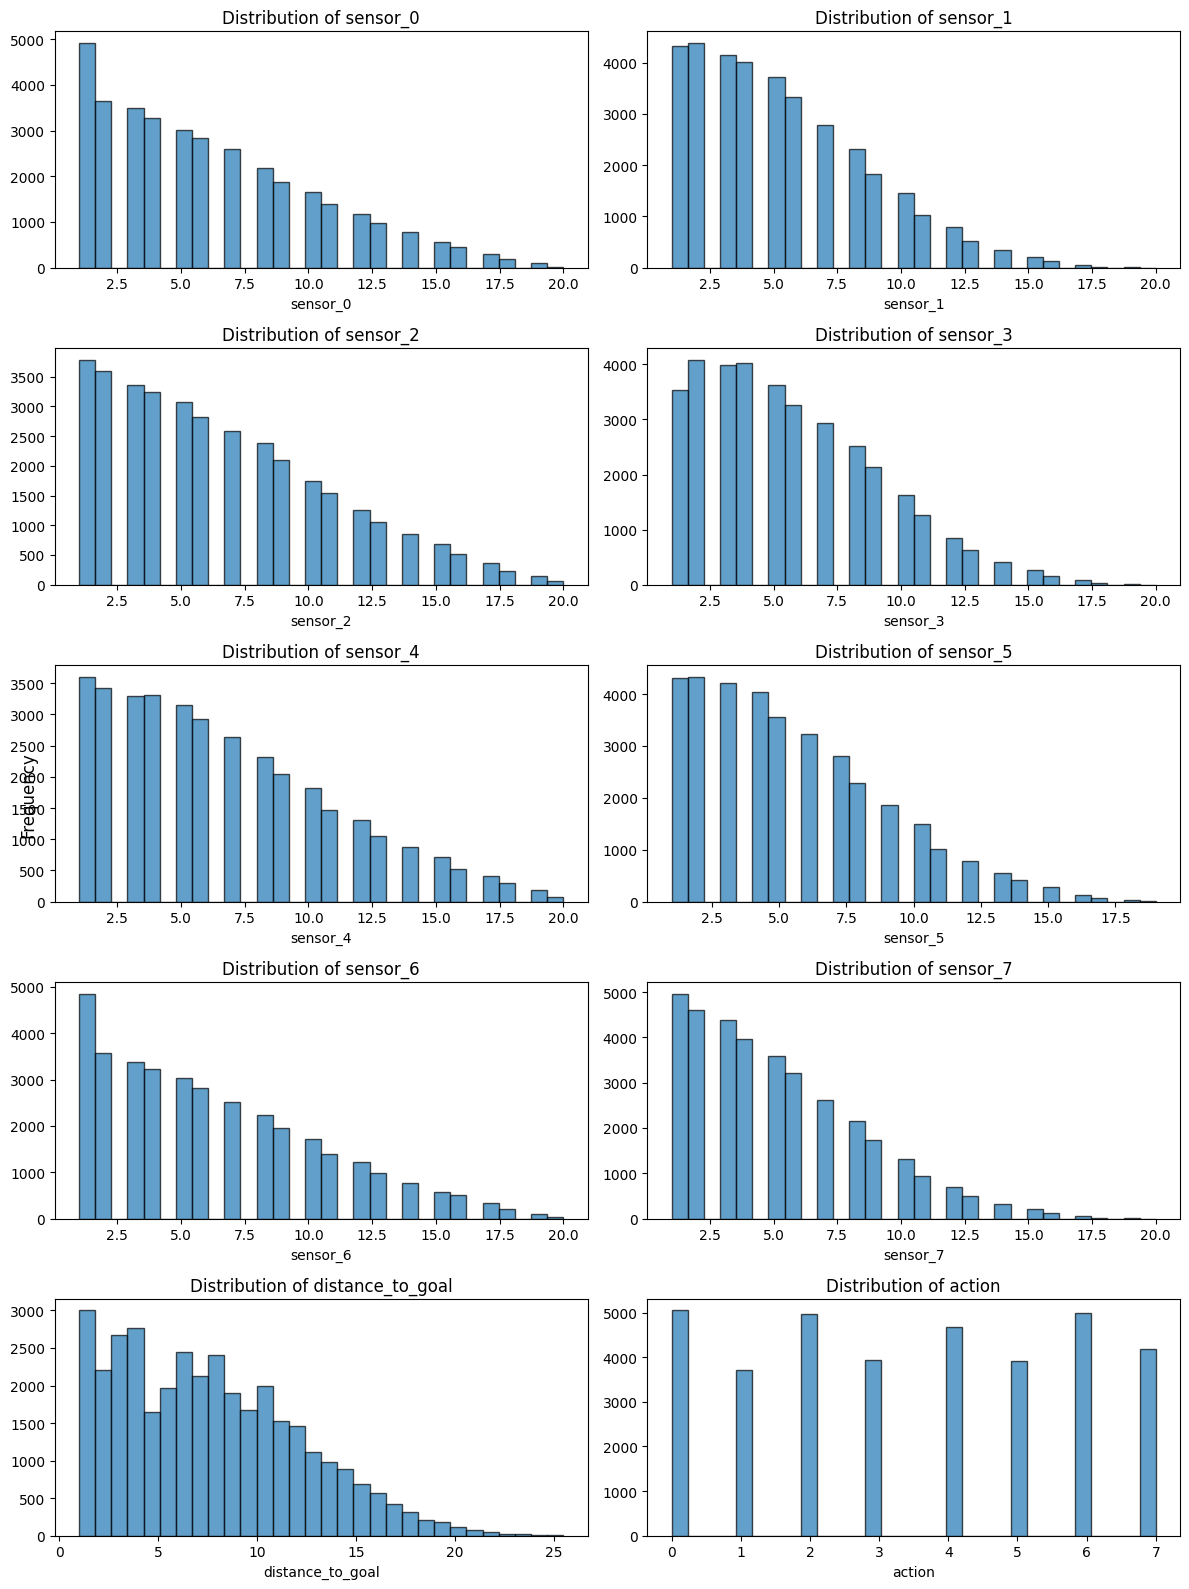

In [36]:
# Example usage:
# Load your data
df = pd.read_csv('../training_data.csv')

# Plot histograms for sensor readings
sensor_cols = [f'sensor_{i}' for i in range(8)] + ['distance_to_goal', 'action']
histogram_plots(df, sensor_cols, 2, figsize=(12, 16))



In [37]:
# Most common action for each sensor pattern
def analyze_predictability():
    # Discretize sensor readings into bins for analysis
    df_binned = df.copy()
    for i in range(8):
        df_binned[f'sensor_{i}'] = pd.cut(df[f'sensor_{i}'], bins=3, labels=['Close', 'Medium', 'Far'])
    
    # Find most common action for each combination
    most_common_actions = df_binned.groupby([f'sensor_{i}' for i in range(8)])['action'].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0])
    
    print(f"Found {len(most_common_actions)} unique sensor patterns")
    print("Sample patterns and their most common actions:")
    for pattern, action in most_common_actions.head(10).items():
        print(f"  {pattern} → Action {action}")

analyze_predictability()

Found 6561 unique sensor patterns
Sample patterns and their most common actions:
  ('Close', 'Close', 'Close', 'Close', 'Close', 'Close', 'Close', 'Close') → Action 2.0
  ('Close', 'Close', 'Close', 'Close', 'Close', 'Close', 'Close', 'Medium') → Action 7.0
  ('Close', 'Close', 'Close', 'Close', 'Close', 'Close', 'Close', 'Far') → Action 7.0
  ('Close', 'Close', 'Close', 'Close', 'Close', 'Close', 'Medium', 'Close') → Action 0.0
  ('Close', 'Close', 'Close', 'Close', 'Close', 'Close', 'Medium', 'Medium') → Action 0.0
  ('Close', 'Close', 'Close', 'Close', 'Close', 'Close', 'Medium', 'Far') → Action 7.0
  ('Close', 'Close', 'Close', 'Close', 'Close', 'Close', 'Far', 'Close') → Action 0.0
  ('Close', 'Close', 'Close', 'Close', 'Close', 'Close', 'Far', 'Medium') → Action 7.0
  ('Close', 'Close', 'Close', 'Close', 'Close', 'Close', 'Far', 'Far') → Action 7.0
  ('Close', 'Close', 'Close', 'Close', 'Close', 'Medium', 'Close', 'Close') → Action 1.0


/var/folders/ck/sr6gtz6n0jx9dmp9nlplxl_w0000gn/T/ipykernel_10359/607456600.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  most_common_actions = df_binned.groupby([f'sensor_{i}' for i in range(8)])['action'].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0])


In [38]:
# Find identical inputs with different outputs (the core ML problem)
def find_conflicting_labels(df):
    feature_cols = [f'sensor_{i}' for i in range(8)] + ['distance_to_goal']
    if 'goal_direction' in df.columns:
        feature_cols.append('goal_direction')
    
    # Group by features and count unique actions
    conflicts = df.groupby(feature_cols)['action'].nunique()
    conflicted_states = conflicts[conflicts > 1]
    
    print(f"States with conflicting labels: {len(conflicted_states)} / {len(conflicts)} ({len(conflicted_states)/len(conflicts):.1%})")
    print(f"Max conflicts per state: {conflicts.max()}")
    
    # Show worst examples
    worst_conflicts = conflicts.sort_values(ascending=False).head(5)
    print("\nWorst conflicting states:")
    for state, num_actions in worst_conflicts.items():
        mask = True
        for i, col in enumerate(feature_cols):
            mask &= (df[col] == state[i])
        actions = df[mask]['action'].value_counts()
        print(f"  {num_actions} actions for state {state[:3]}...: {dict(actions)}")

find_conflicting_labels(df)


States with conflicting labels: 0 / 35452 (0.0%)
Max conflicts per state: 1

Worst conflicting states:
  1 actions for state (1, 1, 1)...: {0: np.int64(1)}
  1 actions for state (7, 11, 2)...: {3: np.int64(1)}
  1 actions for state (7, 10, 18)...: {5: np.int64(1)}
  1 actions for state (7, 11, 1)...: {7: np.int64(1)}
  1 actions for state (7, 11, 1)...: {3: np.int64(1)}


In [39]:
# Quantify how severe the class imbalance is
def analyze_class_imbalance(df):
    action_counts = df['action'].value_counts().sort_index()
    
    # Calculate imbalance metrics
    majority_class = action_counts.max()
    minority_class = action_counts.min()
    imbalance_ratio = majority_class / minority_class
    
    # Effective number of samples (accounts for imbalance)
    beta = 0.9999
    effective_nums = [(1 - beta**count) / (1 - beta) for count in action_counts]
    
    print(f"Class imbalance analysis:")
    print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")
    print(f"  Majority class: {majority_class} samples ({majority_class/len(df):.1%})")
    print(f"  Minority class: {minority_class} samples ({minority_class/len(df):.1%})")
    
    # Show which actions are rare
    rare_actions = action_counts[action_counts < action_counts.mean() * 0.1]
    print(f"\nRare actions (< 10% of average):")
    for action, count in rare_actions.items():
        print(f"  Action {action}: {count} samples ({count/len(df):.2%})")
    
    return imbalance_ratio, rare_actions

imbalance_ratio, rare_actions = analyze_class_imbalance(df)


Class imbalance analysis:
  Imbalance ratio: 1.4:1
  Majority class: 5050 samples (14.2%)
  Minority class: 3704 samples (10.4%)

Rare actions (< 10% of average):


## Machine Learning Convergence Analysis

This study **diagnoses why machine learning models fail to learn** from your robot navigation data by analyzing 6 core learning obstacles.

## What This Analysis Does

Instead of just saying "our model only gets 37% accuracy," this study **explains WHY** by revealing specific mathematical obstacles to machine learning convergence.

### 1. Label Noise & Conflicting Examples
- **Purpose**: Finds identical sensor readings that require different actions
- **Problem**: The "impossible to learn" scenario where same inputs have different correct outputs
- **Impact**: Model gets contradictory training signals → gradient confusion

### 2. Class Imbalance Impact  
- **Purpose**: Quantifies how severely some actions are underrepresented
- **Problem**: Rare but critical actions (like detours) get ignored during training
- **Impact**: Model becomes biased toward majority classes → poor performance on edge cases

### 3. Feature Separability Analysis
- **Purpose**: Tests if features can actually distinguish between different actions using Linear Discriminant Analysis
- **Problem**: Features may not contain enough information to separate action classes
- **Impact**: Even perfect algorithms can't learn if classes aren't separable → fundamental data limitation

### 4. Decision Boundary Complexity
- **Purpose**: Measures how deep decision trees need to be to capture patterns
- **Problem**: Complex boundaries require complex models (overfitting risk) vs simple boundaries (underfitting)
- **Impact**: Indicates optimal model complexity and overfitting tendency

### 5. Local vs Global Pattern Consistency
- **Purpose**: Checks if same patterns mean different things in different contexts
- **Problem**: Sensor patterns might require different actions when close vs far from goal
- **Impact**: Context-dependent decisions confuse models → inconsistent learning signals

### 6. Gradient/Learning Signal Quality
- **Purpose**: Analyzes if similar states have similar actions (smooth learning landscape)
- **Problem**: Noisy neighborhoods where nearby states have different optimal actions
- **Impact**: Gradients point in conflicting directions → unstable training

## The Key Insight

This is a **diagnostic toolkit** that pinpoints exactly what makes your dataset "unlearnable" and quantifies each problem so you know which issues to fix first.

## Expected Findings

**Without goal_direction:**
- High label conflicts (~72% of states)
- Poor feature separability 
- Complex decision boundaries needed
- Inconsistent local patterns
- Noisy learning signals

**With goal_direction:**
- Dramatically reduced label conflicts
- Better feature separability
- Simpler decision boundaries
- More consistent patterns
- Smoother learning signals

## Bottom Line

Rather than guessing why your ML models struggle, this analysis provides **quantitative evidence** of specific obstacles:

- **High label conflicts** → Model gets contradictory training signals
- **Severe imbalance** → Model ignores rare but critical actions  
- **Poor separability** → Features can't distinguish actions linearly
- **High complexity** → Simple models underfit, complex ones overfit
- **Inconsistent patterns** → Same inputs mean different things in different contexts
- **Noisy signals** → Gradients point in conflicting directions

Each analysis directly explains a specific failure mode and helps prioritize which data or modeling issues to address first.


In [51]:
# How well can features separate different actions?
def analyze_feature_separability(df, include_goal_direction=True):
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.preprocessing import StandardScaler
    
    # Explicitly choose features based on parameter
    if include_goal_direction:
        feature_cols = [f'sensor_{i}' for i in range(8)] + ['distance_to_goal', 'goal_direction']
        scenario_name = "With goal_direction"
    else:
        feature_cols = [f'sensor_{i}' for i in range(8)] + ['distance_to_goal']
        scenario_name = "Without goal_direction"
    
    print(f"=== Feature Separability Analysis - {scenario_name} ===")
    
    X = df[feature_cols].values
    y = df['action'].values
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Try LDA to see how separable classes are
    try:
        lda = LinearDiscriminantAnalysis()
        X_lda = lda.fit_transform(X_scaled, y)
        
        # Plot first 2 LDA components
        plt.figure(figsize=(12, 5))
        plt.suptitle(f'Feature Separability Analysis - {scenario_name}')
        
        plt.subplot(1, 2, 1)
        for action in sorted(df['action'].unique()):
            mask = y == action
            if X_lda[mask].shape[0] > 0:
                plt.scatter(X_lda[mask, 0], X_lda[mask, 1] if X_lda.shape[1] > 1 else np.zeros(mask.sum()), 
                           alpha=0.5, label=f'Action {action}', s=10)
        plt.xlabel('LDA Component 1')
        plt.ylabel('LDA Component 2')
        plt.title('Linear Discriminant Analysis')
        plt.legend()
        
        # Feature importance from LDA
        plt.subplot(1, 2, 2)
        feature_importance = np.abs(lda.coef_[0] if len(lda.coef_.shape) == 2 else lda.coef_)
        plt.bar(range(len(feature_cols)), feature_importance)
        plt.xticks(range(len(feature_cols)), feature_cols, rotation=45)
        plt.title('Feature Discriminative Power')
        plt.tight_layout()
        plt.show()
        
        print(f"LDA explained variance ratio: {lda.explained_variance_ratio_[:3]}")
        
    except Exception as e:
        print(f"LDA failed: {e}")


=== Feature Separability Analysis - Without goal_direction ===


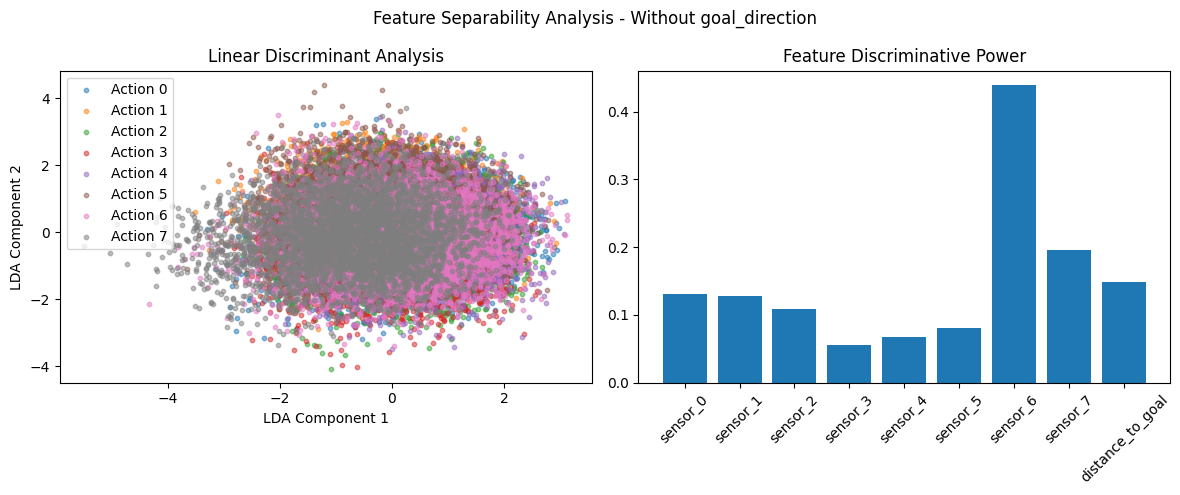

LDA explained variance ratio: [0.34313234 0.25527979 0.2434876 ]


In [49]:
analyze_feature_separability(df, False)

=== Feature Separability Analysis - With goal_direction ===


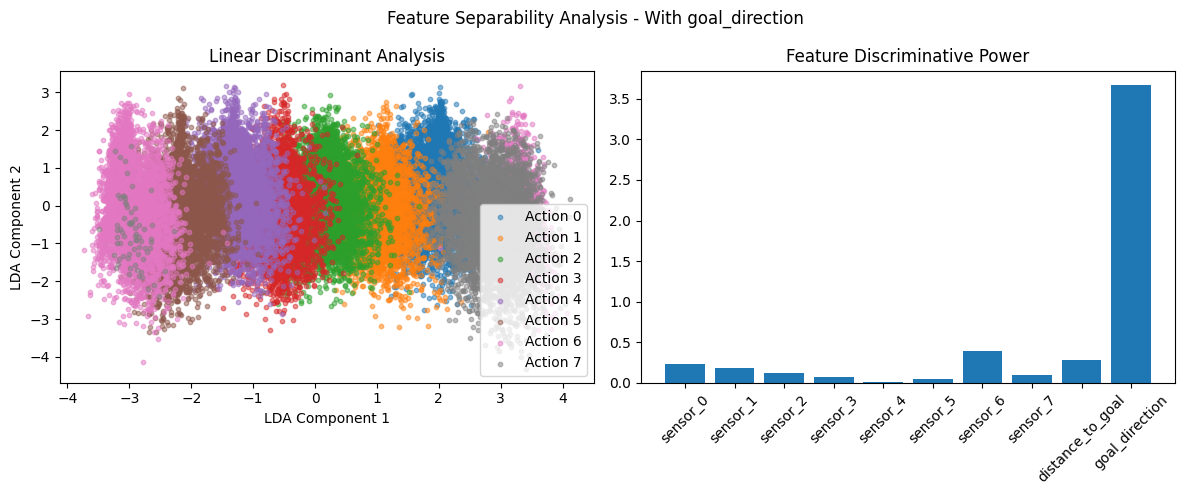

LDA explained variance ratio: [0.91389696 0.03085718 0.02480169]


In [50]:
analyze_feature_separability(df, True)

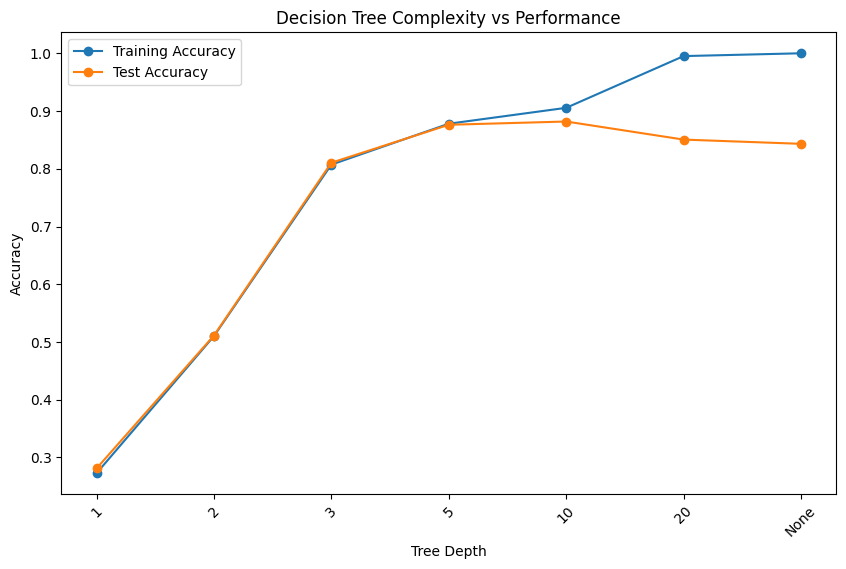

Best tree depth: 10 (Test accuracy: 0.882)


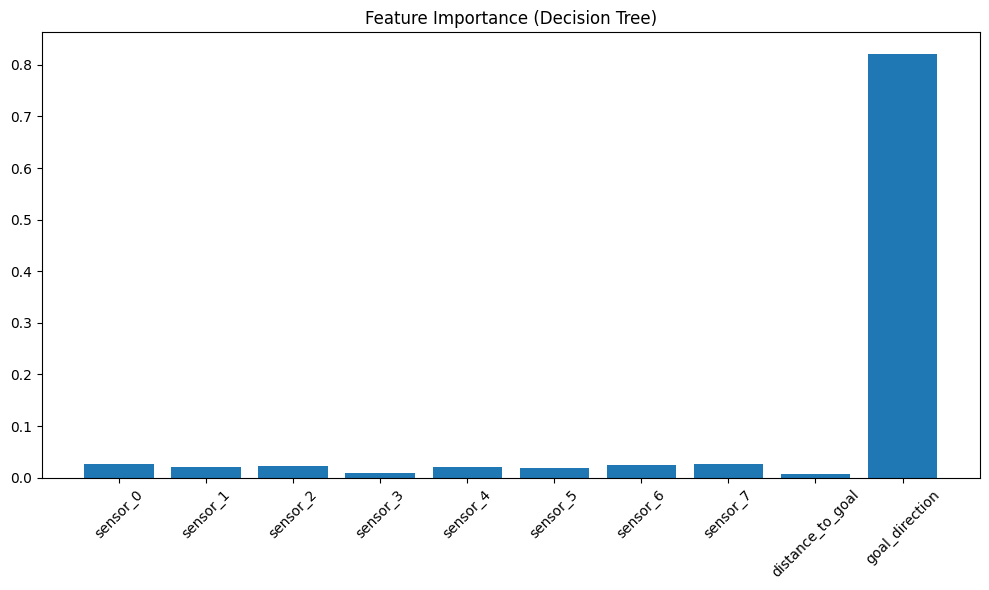

In [41]:
# How complex are the decision boundaries?
def analyze_decision_complexity(df):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    
    feature_cols = [f'sensor_{i}' for i in range(8)] + ['distance_to_goal']
    if 'goal_direction' in df.columns:
        feature_cols.append('goal_direction')
    
    X = df[feature_cols]
    y = df['action']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Test different tree depths
    depths = [1, 2, 3, 5, 10, 20, None]
    train_scores = []
    test_scores = []
    
    for depth in depths:
        dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
        dt.fit(X_train, y_train)
        train_scores.append(dt.score(X_train, y_train))
        test_scores.append(dt.score(X_test, y_test))
    
    plt.figure(figsize=(10, 6))
    plt.plot([str(d) for d in depths], train_scores, 'o-', label='Training Accuracy')
    plt.plot([str(d) for d in depths], test_scores, 'o-', label='Test Accuracy')
    plt.xlabel('Tree Depth')
    plt.ylabel('Accuracy')
    plt.title('Decision Tree Complexity vs Performance')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    
    # Find optimal depth
    best_depth_idx = np.argmax(test_scores)
    best_depth = depths[best_depth_idx]
    print(f"Best tree depth: {best_depth} (Test accuracy: {test_scores[best_depth_idx]:.3f})")
    
    # Show feature importance for best tree
    best_tree = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
    best_tree.fit(X_train, y_train)
    
    plt.figure(figsize=(10, 6))
    plt.bar(feature_cols, best_tree.feature_importances_)
    plt.title('Feature Importance (Decision Tree)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

analyze_decision_complexity(df)


Action distribution by distance to goal:
action                 0      1      2      3      4      5      6      7
distance_quartile                                                        
Very Close         0.171  0.080  0.166  0.119  0.158  0.084  0.171  0.052
Close              0.148  0.104  0.144  0.117  0.134  0.108  0.144  0.102
Far                0.129  0.114  0.130  0.106  0.125  0.120  0.128  0.147
Very Far           0.120  0.122  0.120  0.102  0.110  0.133  0.118  0.175


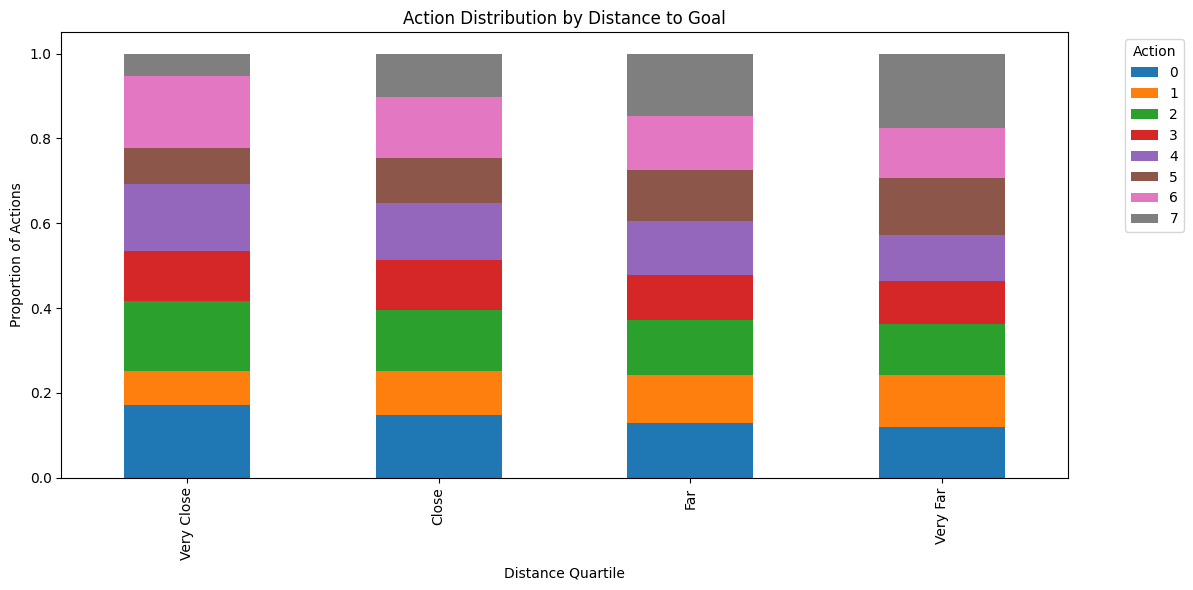


Sensor reading patterns by distance:

Far (n=8499):
Avg sensor readings: ['6.2', '5.6', '6.5', '5.9', '6.7', '5.6', '6.3', '5.3']
  Most common action: 7

Close (n=8836):
Avg sensor readings: ['6.2', '5.6', '6.6', '5.9', '6.8', '5.6', '6.4', '5.3']
  Most common action: 0

Very Close (n=9291):
Avg sensor readings: ['6.0', '5.1', '6.5', '5.4', '6.6', '5.2', '6.1', '4.8']
  Most common action: 6

Very Far (n=8826):
Avg sensor readings: ['6.0', '5.1', '6.4', '5.4', '6.4', '5.1', '6.1', '5.0']
  Most common action: 7


In [42]:
# Are patterns consistent locally vs globally?
def analyze_pattern_consistency(df):
    # Divide data by distance to goal (local vs global context)
    df['distance_quartile'] = pd.qcut(df['distance_to_goal'], q=4, labels=['Very Close', 'Close', 'Far', 'Very Far'])
    
    print("Action distribution by distance to goal:")
    crosstab = pd.crosstab(df['distance_quartile'], df['action'], normalize='index')
    print(crosstab.round(3))
    
    # Visualize
    crosstab.plot(kind='bar', figsize=(12, 6), stacked=True)
    plt.title('Action Distribution by Distance to Goal')
    plt.xlabel('Distance Quartile')
    plt.ylabel('Proportion of Actions')
    plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Check if sensor patterns mean different things at different distances
    print("\nSensor reading patterns by distance:")
    for quartile in df['distance_quartile'].unique():
        subset = df[df['distance_quartile'] == quartile]
        print(f"\n{quartile} (n={len(subset)}):")
        avg_sensors = [subset[f'sensor_{i}'].mean() for i in range(8)]
        print(f"Avg sensor readings: {[f'{x:.1f}' for x in avg_sensors]}")
        print(f"  Most common action: {subset['action'].mode().iloc[0]}")

analyze_pattern_consistency(df)


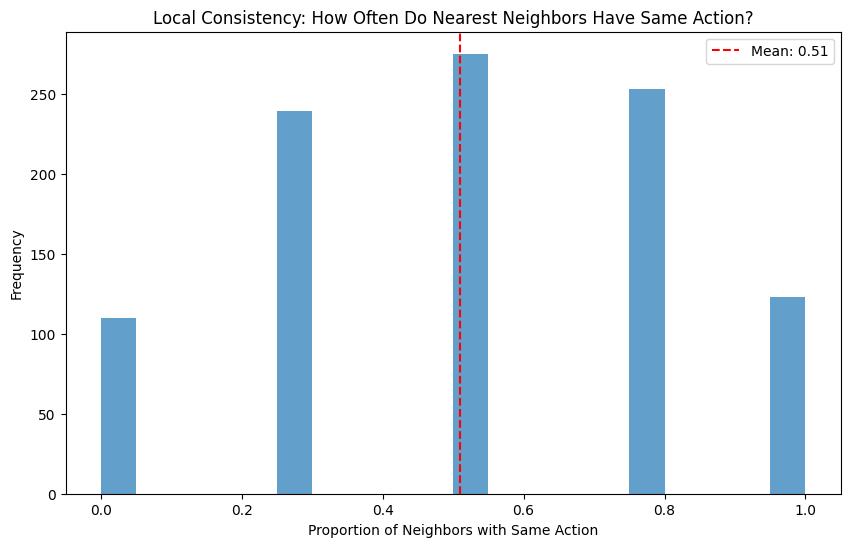

Average neighbor consistency: 0.510
States with <50% neighbor agreement: 34.9%


In [43]:
# How smooth are the transitions between similar states?
def analyze_learning_signals(df):
    feature_cols = [f'sensor_{i}' for i in range(8)] + ['distance_to_goal']
    if 'goal_direction' in df.columns:
        feature_cols.append('goal_direction')
    
    # Sample pairs of nearby states
    from sklearn.neighbors import NearestNeighbors
    from sklearn.preprocessing import StandardScaler
    
    X = df[feature_cols].values
    y = df['action'].values
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Find nearest neighbors
    nn = NearestNeighbors(n_neighbors=5)
    nn.fit(X_scaled)
    
    # Check how often nearest neighbors have same action
    distances, indices = nn.kneighbors(X_scaled[:1000])  # Sample first 1000 points
    
    same_action_rates = []
    for i in range(1000):
        neighbors = indices[i, 1:]  # Exclude self
        neighbor_actions = y[neighbors]
        same_action_rate = (neighbor_actions == y[i]).mean()
        same_action_rates.append(same_action_rate)
    
    plt.figure(figsize=(10, 6))
    plt.hist(same_action_rates, bins=20, alpha=0.7)
    plt.xlabel('Proportion of Neighbors with Same Action')
    plt.ylabel('Frequency')
    plt.title('Local Consistency: How Often Do Nearest Neighbors Have Same Action?')
    plt.axvline(np.mean(same_action_rates), color='red', linestyle='--', label=f'Mean: {np.mean(same_action_rates):.2f}')
    plt.legend()
    plt.show()
    
    print(f"Average neighbor consistency: {np.mean(same_action_rates):.3f}")
    print(f"States with <50% neighbor agreement: {(np.array(same_action_rates) < 0.5).mean():.1%}")

analyze_learning_signals(df)


In [44]:
# Histogram plotting function for continuous variables
def histogram_plots(df, columns, num_cols, bins=30, figsize=(12, 8)):
    """
    Create histogram plots for multiple variables in a grid layout.
    
    Parameters:
    df (DataFrame): The pandas DataFrame containing the data
    columns (list): List of column names to plot
    num_cols (int): Number of columns in the grid layout
    bins (int): Number of bins for histograms (default: 30)
    figsize (tuple): Figure size (width, height) (default: (12, 8))
    """
    n_plots = len(columns)
    n_cols = num_cols
    n_rows = int(math.ceil(n_plots/n_cols))
    gs = gridspec.GridSpec(n_rows, n_cols)
    fig = plt.figure(figsize=figsize)
    
    for i in range(n_plots):
        ax = fig.add_subplot(gs[i])
        df[columns[i]].hist(ax=ax, bins=bins, grid=False, alpha=0.7, edgecolor='black')
        ax.set_xlabel(columns[i])
        ax.set_title(f'Distribution of {columns[i]}')
    
    fig.tight_layout()
    fig.supylabel('Frequency')
    plt.show()
